In [2]:
:dep plotly = { version = "=0.8.0" } # 0.8.1 has breaking changes
:dep itertools-num = "0.1.3"
:dep num = "0.4.0"

In [3]:
#![allow(warnings)]

In [4]:
use itertools_num::linspace;
use plotly::common::{
    ColorScale, ColorScalePalette, DashType, Fill, Font, Line, LineShape, Marker, Mode, Title,
};
use plotly::layout::{Axis, BarMode, Layout, Legend, TicksDirection};
use plotly::{Bar, Plot, Scatter};

In [5]:
use num::complex::Complex;

In [6]:
// parameters
struct Parameters {
    phase_offset: f32, // carrier phase offset
    freq_offset: f32,  // carrier frequency offset
    wn: f32,           // pll bandwidth
    zeta: f32,         // pll damping factor
    K: f32,            // pll loop gain
    n: usize,          // number of samples
}

// constants
struct Constants {
    b:  (f32, f32, f32),  // feed-forward coefficients (numerator)
    a:  (f32, f32, f32),  // feed-back coefficients (denominator)
}

// state
struct State {
    v: (f32, f32, f32), // filter  
    phi: f32,           // input signal phase
    phi_hat: f32,       // pll output signal phase
}

In [7]:
/// run simulation
fn simulate(P: &Parameters) -> (Vec<f32>, Vec<f32>, Vec<f32>, Vec<f32>, Vec<f32>, Vec<f32>, Vec<f32>) {
    let mut signal_xre = vec![0.0; P.n];
    let mut signal_xim = vec![0.0; P.n];
    let mut signal_yre = vec![0.0; P.n];
    let mut signal_yim = vec![0.0; P.n];
    let mut signal_err = vec![0.0; P.n];
    let mut signal_phi = vec![0.0; P.n];
    let mut signal_phi_hat = vec![0.0; P.n];    
    
    // calculate filter coefficients
    let Parameters { K, wn, zeta, ..} = P;    
    let tau_1 = K / (wn * wn);
    let tau_2 = 2. * (zeta / wn);
    let b = (
        (4. * (K / tau_1)) * (1. + (tau_2 / 2.)), 
        (8. * (K / tau_1)),  
        (4. * (K / tau_1)) * (1. - (tau_2 / 2.))
    );
    let a = (1.0, -2.0,  1.0);

    //println!("#  b = [b0:{:12.8}, b1:{:12.8}, b2:{:12.8}", b.0, b.1, b.2);
    //println!("#  a = [a0:{:12.8}, a1:{:12.8}, a2:{:12.8}", a.0, a.1, a.2);
        
    let C = Constants { b, a };
    let mut S = State {
        v: (0., 0., 0.),     // filter 
        phi: P.phase_offset, // input signal phase
        phi_hat: 0.,         // pll output signal phase
    };    
    
    for i in 0..P.n {
        // compute input sinusoid and update phase    
        let x = num::complex::Complex::new(f32::cos(S.phi), f32::sin(S.phi));
        S.phi += P.freq_offset;

        // compute PLL output from phase estimate    
        let y = num::complex::Complex::new(f32::cos(S.phi_hat), f32::sin(S.phi_hat));

        // compute error estimate
        let delta_phi = (x * y.conj()).arg();

        // push result through loop filter, updating phase estimate
        S.v.2 = S.v.1;  
        S.v.1 = S.v.0;  
        S.v.0 = delta_phi - (S.v.1 * C.a.1) - (S.v.2 * C.a.2); 

        // compute new pll output phase
        S.phi_hat = (S.v.0 * C.b.0) + (S.v.1 * C.b.1) + (S.v.2 * C.b.2);
        
        // log signals
        signal_xre[i] = x.re;
        signal_xim[i] = x.im;
        signal_yre[i] = y.re;
        signal_yim[i] = y.im;
        signal_err[i] = delta_phi;
        signal_phi[i] = S.phi;
        signal_phi_hat[i] = S.phi_hat;
    }
    
    (signal_xre, signal_xim, signal_yre, signal_yim, signal_err, signal_phi, signal_phi_hat)
}

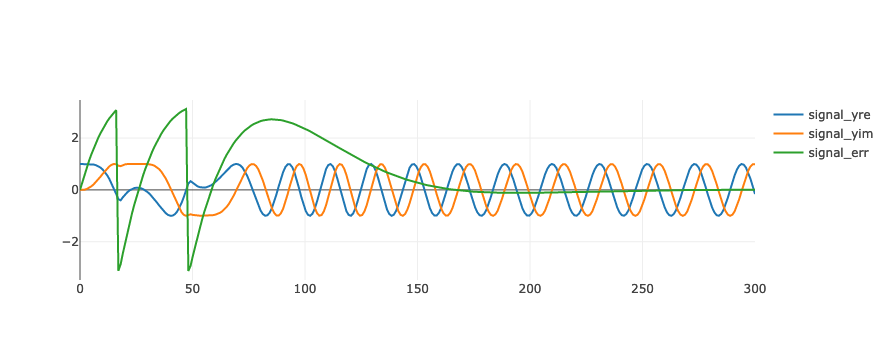

In [8]:
// set parameters
let parameters = Parameters {
    phase_offset: 0.,    // carrier phase offset        0.0
    freq_offset:  0.3,   // carrier frequency offset    0.3
    wn:           0.01,  // pll bandwidth               0.01
    zeta:         0.707, // pll damping factor          0.707
    K:            1000., // pll loop gain               1000.
    n:            300,   // number of samples           400
};
let t = parameters.n as f32;

let xs: Vec<f32> = linspace(0., t, parameters.n).collect();
let signals = simulate(&parameters);

let mut plot = Plot::new();
//plot.add_trace(Scatter::new(xs.clone(), signals.0).mode(Mode::Lines).name("signal_xre"));
//plot.add_trace(Scatter::new(xs.clone(), signals.1).mode(Mode::Lines).name("signal_xim"));
plot.add_trace(Scatter::new(xs.clone(), signals.2).mode(Mode::Lines).name("signal_yre"));
plot.add_trace(Scatter::new(xs.clone(), signals.3).mode(Mode::Lines).name("signal_yim"));
plot.add_trace(Scatter::new(xs.clone(), signals.4).mode(Mode::Lines).name("signal_err"));
//plot.add_trace(Scatter::new(xs.clone(), signals.5).mode(Mode::Lines).name("signal_phi"));
//plot.add_trace(Scatter::new(xs.clone(), signals.6).mode(Mode::Lines).name("signal_phi_hat"));

plot.set_layout(Layout::new().height(200));
plot.lab_display();

## References

* [Writing a Phase-locked Loop in Straight C](https://liquidsdr.org/blog/pll-howto/)